# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import os, cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
from keras import backend as K
K.set_image_data_format('channels_last') 
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l1, l2


import glob
import h5py
import tensorflow as tf

# Model Evaluation Libraries
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report

# Connect to Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read Label files

In [3]:
import json
with open('/content/drive/MyDrive/data/train.jsonl') as f:        
    train_label_data = [json.loads(line) for line in f]

In [4]:
import json
with open('/content/drive/MyDrive/data/dev.jsonl') as f:
    dev_label_data = [json.loads(line) for line in f]

In [5]:
len(train_label_data), len(dev_label_data)

(8500, 500)

In [6]:
train_label_data[0]

{'id': 42953,
 'img': 'img/42953.png',
 'label': 0,
 'text': 'its their character not their color that matters'}

In [ ]:
# Make text Dataframe

In [7]:
df_text = pd.DataFrame(train_label_data + dev_label_data )

In [8]:
df_text.shape

(9000, 4)

In [9]:
df_text.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [10]:
df_text

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
8995,83675,img/83675.png,0,i'm gonna be like phelps one day
8996,37198,img/37198.png,0,when you're so relaxed you can feel yourself g...
8997,48670,img/48670.png,0,look at this sandwich maker club i found on wi...
8998,9863,img/09863.png,0,diverse group of women


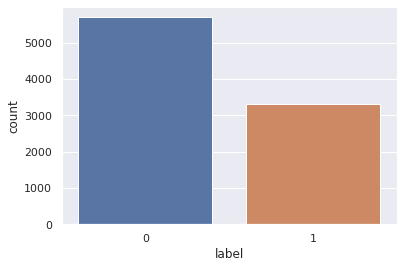

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")

ax = sns.countplot(x="label", data=df_text)

In [ ]:
# Preprocessing Of Text Data

In [12]:
df_text['preprocessed']  = df_text['text'].str.lower()

In [13]:
import re
def clean_text(text):
    text = re.sub('[^ a-zA-Z0-9]', '', text) 
    text = re.sub(r"\W"," ",text)
    text = re.sub(r"\d"," ",text)
    text = re.sub(r"\s+[a-z]\s+"," ",text)
    text = re.sub(r"\s+[a-z]$"," ",text)
    text = re.sub(r"^[a-z]\s+"," ",text)
    text = re.sub(r"\s+"," ",text) 
    return  text
df_text['preprocessed']  = df_text['preprocessed'].apply(clean_text)

In [14]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df_text['preprocessed'] = df_text['preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [16]:
import spacy
nlp = spacy.blank('en')

def tokenizer(sent):    
    doc = nlp.tokenizer(sent)
    return [i.text for i in doc]

df_text["preprocessed"] = df_text["preprocessed"].apply(tokenizer)

In [17]:
df_text.head()

,id,img,label,text,preprocessed
0,42953,img/42953.png,0,its their character not their color that matters,"[character, color, matters]"
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,"[do, nt, afraid, love, everyone, like, ex]"
2,13894,img/13894.png,0,putting bows on your pet,"[putting, bows, pet]"
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,"[love, everything, everybody, except, squirrel..."
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...","[everybody, loves, chocolate, chip, cookies, e..."


In [18]:
df_text['len_preprocessed']  = df_text['preprocessed'].str.len()

In [19]:
df_text['len_preprocessed'].max()  

45

In [20]:
import gensim
model_word2vec = gensim.models.Word2Vec(df_text["preprocessed"], size=64, window=3, workers=10, min_count = 1, sg =0)

In [21]:
model_word2vec.wv.most_similar("pet")

[('culture', 0.9901975989341736),
 ('sandwich', 0.9897231459617615),
 ('place', 0.9897178411483765),
 ('obama', 0.9897117614746094),
 ('take', 0.9895206689834595),
 ('gives', 0.9894942045211792),
 ('time', 0.989482581615448),
 ('cute', 0.9894720315933228),
 ('find', 0.9894657731056213),
 ('food', 0.9894459843635559)]

In [22]:
model_word2vec.wv.most_similar("chocolate")

[('power', 0.9871658086776733),
 ('islamic', 0.9852335453033447),
 ('year', 0.9851807355880737),
 ('wrong', 0.9849326014518738),
 ('found', 0.9849033355712891),
 ('bitches', 0.9848842620849609),
 ('show', 0.9846093058586121),
 ('rashida', 0.9845809936523438),
 ('family', 0.9845095872879028),
 ('better', 0.984367847442627)]

In [23]:
VOCAB_SIZE = len(model_word2vec.wv.vocab)
DIMENSIONS = 64
MAX_LEN = df_text['len_preprocessed'].max()  

In [24]:
VOCAB_SIZE, DIMENSIONS, MAX_LEN

(8888, 64, 45)

In [25]:
from keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts( df_text['preprocessed'])
encoded = token.texts_to_sequences(df_text["preprocessed"])

In [26]:
words2vec_matrix = np.zeros((VOCAB_SIZE+1, DIMENSIONS))

for word, index in token.word_index.items():
    try:
        words2vec_matrix[index] = model_word2vec.wv[word]
    except:
        print(index, word)


In [27]:
import tensorflow as tf
train_vectors = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post', dtype=int)

In [28]:
train_label = df_text['label']

In [29]:
(train_sentences, test_sentences, train_tags, test_tags) = train_test_split(train_vectors, train_label, test_size=0.2, shuffle = True)

In [30]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
from tensorflow.keras.optimizers import Adam, Optimizer, SGD
import tensorflow.keras.initializers as Init
from tensorflow.keras import regularizers

In [32]:
lstm = Models.Sequential()

lstm.add(Layers.Embedding(VOCAB_SIZE+1,DIMENSIONS,
                          embeddings_initializer = Init.Constant(words2vec_matrix),
                          input_length=MAX_LEN, trainable=False ))

lstm.add(Layers.Bidirectional(Layers.LSTM(64, activation='relu')))

lstm.add(Layers.Dense(128, activation='relu'))
lstm.add(Layers.Dropout(0.3))

lstm.add(Layers.Dense(64, activation='relu'))
lstm.add(Layers.Dropout(0.3))

lstm.add(Layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 64)            568896    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [35]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
class_weight={0: 25,
                1: 50.,}

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es_callback = EarlyStopping(monitor='val_loss', patience=3) 
LSTM_NET = lstm.fit(train_sentences, train_tags, epochs=50, validation_split=0.02, class_weight=class_weight , callbacks=[es_callback], shuffle=False)

Epoch 1/50
221/221 [==============================] - 33s 139ms/step - loss: 23.4340 - accuracy: 0.4962 - val_loss: 0.7036 - val_accuracy: 0.5347
Epoch 2/50
221/221 [==============================] - 30s 137ms/step - loss: 23.3927 - accuracy: 0.4885 - val_loss: 0.7016 - val_accuracy: 0.5278
Epoch 3/50
221/221 [==============================] - 30s 136ms/step - loss: 23.3790 - accuracy: 0.5071 - val_loss: 0.6973 - val_accuracy: 0.5208
Epoch 4/50
221/221 [==============================] - 30s 134ms/step - loss: 23.3884 - accuracy: 0.4963 - val_loss: 0.7005 - val_accuracy: 0.5069
Epoch 5/50
221/221 [==============================] - 31s 142ms/step - loss: 23.3900 - accuracy: 0.4946 - val_loss: 0.7056 - val_accuracy: 0.5139
Epoch 6/50
221/221 [==============================] - 29s 133ms/step - loss: 23.3604 - accuracy: 0.4973 - val_loss: 0.6951 - val_accuracy: 0.5139
Epoch 7/50
221/221 [==============================] - 31s 141ms/step - loss: 23.3253 - accuracy: 0.4990 - val_loss: 0.7014 -

In [36]:
#seralize model to json
model_json=lstm.to_json()
with open("improvedmodel_lstm.json","w") as json_file:
    json_file.write(model_json)
#seralize weights to HDFS
lstm.save_weights("improvedmodel_lstm.h5")
print("Saved Model To Disk")    

Saved Model To Disk


In [ ]:
#Load Json and Create Model
json_file=open("improvedmodel_lstm.json",'r')
loaded_model_json=json_file.read()
json_file.close()
loaded_model=model_from_json(loaded_model_json)
#Load weights into new model
loaded_model.load_weights("improvedmodel_lstm.h5")
print("Loaded Model from disk")

loaded_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

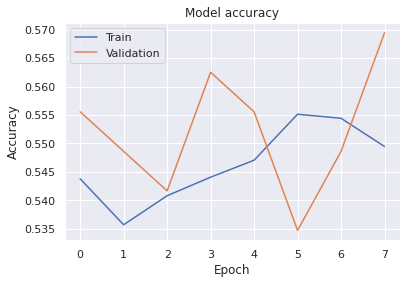

In [ ]:
#Accuracy Curve
plt.plot(LSTM_NET.history['accuracy'])
plt.plot(LSTM_NET.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

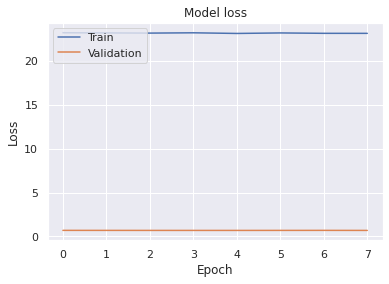

In [ ]:
#Loss Curve
plt.plot(LSTM_NET.history['loss'])
plt.plot(LSTM_NET.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(lstm.predict(test_sentences).round(), test_tags))

              precision    recall  f1-score   support

         0.0       0.60      0.66      0.63       995
         1.0       0.52      0.44      0.48       805

    accuracy                           0.56      1800
   macro avg       0.56      0.55      0.55      1800
weighted avg       0.56      0.56      0.56      1800



In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test_tags, lstm.predict(test_sentences).round())

array([[660, 449],
       [335, 356]])

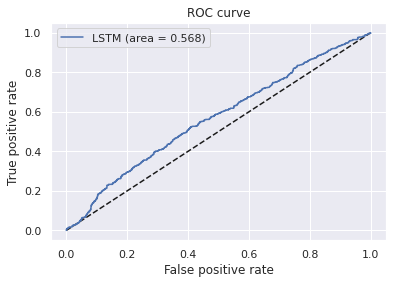

In [ ]:
#ROC Curve AUC
from sklearn.metrics import roc_curve
y_pred = lstm.predict(test_sentences).ravel()
fpr, tpr, thresholds = roc_curve(test_tags, y_pred)

from sklearn.metrics import auc
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LSTM (area = {:.3f})'.format(auc))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()